Code for **"Inpainting"** figures $6$, $8$ and 7 (top) from the main paper. 

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark =False
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64
torch.manual_seed(0)

# Choose figure

In [2]:
## Fig 6
img_path  = 'data/inpainting/vase.png'
mask_path = 'data/inpainting/vase_mask.png'

# Fig 8
# img_path  = 'data/inpainting/library.png'
# mask_path = 'data/inpainting/library_mask.png'

## Fig 7 (top)
# img_path  = 'data/inpainting/kate.png'
# mask_path = 'data/inpainting/kate_mask.png'

# Another text inpainting example
# img_path  = 'data/inpainting/peppers.png'
# mask_path = 'data/inpainting/peppers_mask.png'

NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet
NET_TYPE = 'skip_depth4'

# Load mask

In [3]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

### Center crop

In [4]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

### Visualize

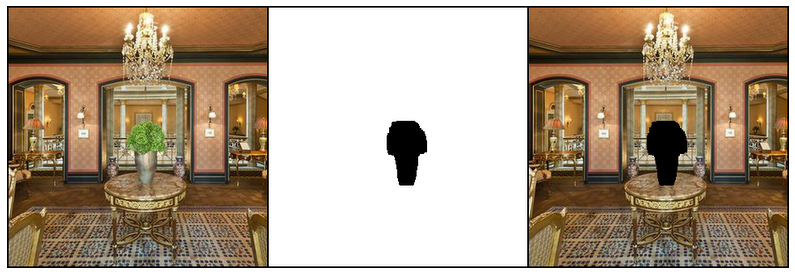

In [5]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);
# plot_image_grid([img_np, img_mask_np*img_np], 2,11);

# Setup

In [6]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'
# OPTIMIZER = 'LBFGS'


In [7]:
if 'vase.png' in img_path:
    INPUT = 'meshgrid'
    input_depth = 3
    LR = 0.10 
    num_iter = 5001#5001
    param_noise = False
    show_every = 100
    figsize = 5
    reg_noise_std = 0.03
    nblocks =4
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [64] * nblocks,
               num_channels_up   = [64] * nblocks,
               num_channels_skip = [0] * nblocks,  
               upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    OPTIMIZER = 'LBFGS'
    
elif ('kate.png' in img_path) or ('peppers.png' in img_path):
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise'
    input_depth = 32
    LR = 0.01 
    num_iter = 6001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    nchan = 64
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [nchan] * 5,
               num_channels_up =   [nchan] * 5,
               num_channels_skip =    [nchan] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif 'library.png' in img_path:
    
    INPUT = 'noise'
    input_depth = 3
    
    num_iter = 3001
    num_iter = 1001
    show_every = 50
    figsize = 8
    reg_noise_std = 0.00
    param_noise = True
    
    if 'skip' in NET_TYPE:
        
        depth = int(NET_TYPE[-1])
        nchan =64
        net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [16, 32, nchan, nchan, nchan, nchan][:depth],
               num_channels_up =   [16, 32, nchan, nchan, nchan, nchan][:depth],
               num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
        
        LR = 0.01 
        
    elif NET_TYPE == 'UNET':
        
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=8, more_layers=1, 
                   concat_x=False, upsample_mode='deconv', 
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
        
        LR = 0.001
        param_noise = False
        
    elif NET_TYPE == 'ResNet':
        
        net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
        
        LR = 0.001
        param_noise = False
        
    else:
        assert False
else:
    assert False

net = net.type(dtype)
# noise = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [8]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 427395


In [9]:
def _init_dcvx_parameters(net_to_dcvx):
    # parameters = [p for p in self.image_net.named_parameters()] + \
    #              [p for p in self.mask_net.named_parameters()]
    #     net_to_dcvx = [self.left_net,self.right_net]
    # if self._is_learning_ambient():
    #     net_to_dcvx.append(self.ambient_net)

    # set_trace()
    parameters = list()
    for net in net_to_dcvx:
        # for name, p  in net.named_parameters():
        #     print(name, end=' ')
        layer_id = 0
        # set_trace()
        for name, p  in net.named_parameters():
            layer_id +=1
            if "weight" in name and layer_id>7 and p.dim()>1:
                parameters.append(p)
                print(name)
    return parameters

def dcvx(parameters):
    neg_weight_reg  = 0.0 
    #parameters =self.dcvx_parameters
    for p in parameters:
        neg_weight_reg += torch.norm(p[p<0])
    return neg_weight_reg

dcvx_ = 1
dcvx_coeff= 0.000002
if 'lib' in img_path:
    dcvx_coeff= 0.00002
if 'vase.png' in img_path:
    dcvx_coeff= 0.00001
parameters = _init_dcvx_parameters([net])
stop_dcvx =0

1.7.1.1.1.weight
1.7.1.4.1.weight
1.7.1.7.1.1.1.weight
1.7.1.7.1.4.1.weight
1.7.1.7.1.7.1.1.1.weight
1.7.1.7.1.7.1.4.1.weight
1.7.1.7.1.7.3.1.weight
1.7.1.7.1.7.6.1.weight
1.7.1.7.3.1.weight
1.7.1.7.6.1.weight
1.7.3.1.weight
1.7.6.1.weight
3.1.weight
6.1.weight
9.1.weight


In [10]:
print(img_pil.size)
img_bicubic_pil = img_pil.resize((img_pil.size[0]*2,img_pil.size[1]*2), Image.BICUBIC)
img_bicubic_np = pil_to_np(img_bicubic_pil)
KERNEL_TYPE='lanczos2'
from models.downsampler import Downsampler
downsampler = Downsampler(n_planes=3, factor=2, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

(320, 320)


# Main loop

Starting optimization with LBFGS


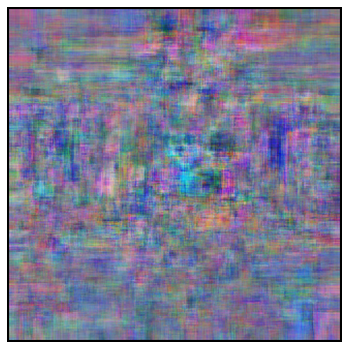

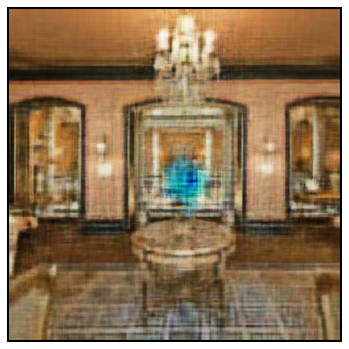

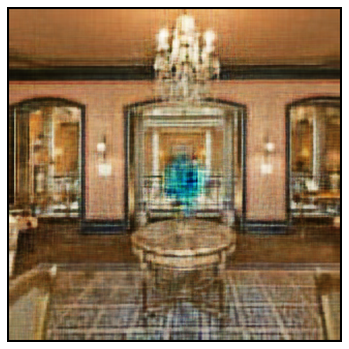

KeyboardInterrupt: 

In [11]:
i = 0

dcvx_=0
def closure():
    
    global i,dcvx_, stop_dcvx,dcvx_coeff,net_input
    
    #if param_noise:for n in [x for x in net.parameters() if len(x.size()) == 4]:n = n + n.detach().clone().normal_() * n.std() / 50
    
    out = net(net_input)
    #out_HR = net(net_input)
    #out = downsampler(out_HR)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    if dcvx_:
        dcvx_loss = mse(net_input* mask_var,net_input_saved * mask_var)
        if i%150==149:
            print("dcvx_loss:"+str(dcvx_loss.data.cpu())+ " total_loss:"+str(total_loss.data.cpu()))
            reg_noise_std=0.0001
            #with torch.no_grad:net_input= (net_input* mask_var + out*(1.0-mask_var))*0.2 + net_input*0.8
        total_loss += dcvx_loss
    """
    if dcvx_ and not stop_dcvx:
        dcvx_loss = dcvx(parameters)*dcvx_coeff
        if i%50==0:
            print("dcvx_loss:"+str(dcvx_loss.data.cpu())+ " total_loss:"+str(total_loss.data.cpu()))
        if dcvx_loss.data.cpu()> 0.5*total_loss.data.cpu():
            dcvx_coeff = dcvx_coeff*0.25
                #stop_dcvx = 1
        total_loss += dcvx_loss
    """
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss
# net_input = torch.from_numpy(img_bicubic_np).type(dtype)
net_input = img_var.clone().type(dtype)

if net_input.dim()<4:
    net_input=net_input.unsqueeze(0)
net_input_saved = net_input.detach().clone()

import torchgeometry as tgm
gauss = tgm.image.GaussianBlur((15, 15), (2.5, 2.5))
net_input = gauss(net_input)  # 2x4x5x5
net_input = gauss(net_input)
# net_input_saved = net_input.detach().clone()
# feat_ref = (net_input_saved*0.3).detach()
# noise = net_input.detach().clone()
net_input.requires_grad =True
OPT_OVER =  'net,input'
p = get_params(OPT_OVER, net, net_input)
# if dcvx_: p=p+[net_input]

OPTIMIZER = 'LBFGS'
optimize(OPTIMIZER, p, closure, LR*3.0, num_iter)
# OPTIMIZER = 'adam'
# optimize(OPTIMIZER, p, closure, LR*1.0, num_iter)

In [ ]:
print(img_var.mean())

out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);

In [ ]:
print(img_var.shape)

In [ ]:
print(p[0].shape)

In [ ]:
p[0].requires_grad

In [ ]:
print(p[-1].shape)

In [ ]:
mask_var.shape